In [1]:
import torch
import numpy as np

import pandas as pd
from matplotlib import pyplot as plt


In [2]:
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    device = torch.device('cuda')
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')


CUDA is not available.  Training on CPU ...


In [3]:
from torchvision import datasets
from torchvision import datasets, transforms
from torch.utils.data.sampler import SubsetRandomSampler
from PIL import Image


In [19]:
class CustomDatasetFromImages():
    def __init__(self, csv_path):
        """
        Args:
            csv_path (string): path to csv file
            img_path (string): path to the folder where images are
            transform: pytorch transforms for transforms and tensor conversion
        """
        # Transforms
        self.resize = transforms.Resize(224)
        #self.center = transforms.CenterCrop(224)
        self.color = transforms.ColorJitter(0.1, 0.1, 0.1, 0.1)
        self.to_tensor = transforms.ToTensor()
        self.normalize = transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        # Read the csv file
        self.data_info = pd.read_csv(csv_path)
        # First column contains the image paths
        self.image_arr = np.asarray(self.data_info.iloc[:, 0])
        # Second column is the labels
        self.label_arr = np.asarray(self.data_info.iloc[:, 1])
        # Third column is for an operation indicator
        self.operation_arr = np.asarray(self.data_info.iloc[:, 2])
        # Calculate len
        self.data_len = len(self.data_info.index)

    def __getitem__(self, index):
        # Get image name from the pandas df
        single_image_name = self.image_arr[index]

        # Open image
        img_as_img = Image.open('images/'+ str(single_image_name)+'.jpg')

        # Transform image to tensor
        img_resize = self.resize(img_as_img)
        img_color = self.color(img_resize)
        img_as_tensor = self.to_tensor(img_color)
        img_normalized = self.normalize(img_as_tensor)

        # Get label(class) of the image based on the cropped pandas column
        single_image_label = self.label_arr[index]

        return (img_as_tensor, single_image_label)

    def __len__(self):
        return self.data_len


In [20]:
# Link to CSV
csv_dir = 'control_data.csv'

# Custom dataset
dataset = CustomDatasetFromImages(csv_dir)

In [21]:
validation_split = .2
shuffle_dataset = True
batch_size=64
random_seed= 42

# Creating data indices for training and validation splits:
dataset_size = len(dataset)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))
if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size)#sampler=train_sampler
validation_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size)#, sampler=valid_sampler


tensor(0., dtype=torch.float64)


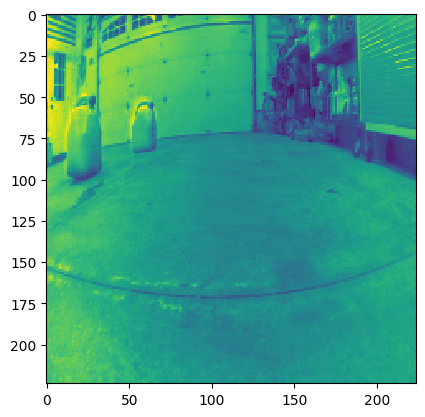

In [22]:
images, labels = next(iter(train_loader))
images = images.numpy()
plt.imshow(images[0][0], interpolation='nearest')
print(labels[0])



In [23]:
import torch.nn as nn
import torch.nn.functional as f

In [24]:
#Add my network
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)


class Network(nn.Module):
    def __init__(self, input_size=3, action=1):
        super(Network, self).__init__()
        self.input_size = input_size  # to define input neurons, currently only 1 image (3 channels) but useful if sensors are used
        self.action = action  # 3 possible actions, turning left, right or straight (some degrees)
        # image size will be  (224,224,3) (if just using images, input size will be 3)
        self.flatten = Flatten()
        self.conv1 = nn.Conv2d(input_size, 24, 5, stride=2, padding=1)
        self.conv2 = nn.Conv2d(24, 32, 5, stride=1, padding=1)
        self.conv3 = nn.Conv2d(32, 64, 5, stride=1, padding=1)
        self.conv4 = nn.Conv2d(64, 64, 3, stride=1, padding=1)
        self.conv5 = nn.Conv2d(64, 64, 3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 3 * 3, 144)
        self.fc2 = nn.Linear(144, action)  # need to read about making the output 3 (action should be set to 1)
        self.dropout = nn.Dropout(0.15)

    def forward(self, current):
        current = self.pool(f.relu(self.conv1(current)))
        current = self.pool(f.relu(self.conv2(current)))
        current = self.pool(f.relu(self.conv3(current)))
        current = self.pool(f.relu(self.conv4(current)))
        current = self.pool(f.relu(self.conv5(current)))

        # flatten image input
        current = self.flatten(current)
        current = self.dropout(current)
        current = f.relu(self.fc1(current))
        current = self.dropout(current)
        res = self.fc2(current)
        return res


In [25]:
#create CNN
model = Network()
print(model)
#move tensors to GPU if available
if train_on_gpu:
  model.cuda

Network(
  (flatten): Flatten()
  (conv1): Conv2d(3, 24, kernel_size=(5, 5), stride=(2, 2), padding=(1, 1))
  (conv2): Conv2d(24, 32, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=576, out_features=144, bias=True)
  (fc2): Linear(in_features=144, out_features=1, bias=True)
  (dropout): Dropout(p=0.15, inplace=False)
)


In [ ]:
import torch.optim as optim
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# number of epochs to train the model
total_epochs = 20

valid_loss_min = np.Inf # track change in validation loss

for epoch in range(1,total_epochs+1):
    train_loss = 0.0
    val_loss = 0.0
    model.train()
    for data, target in train_loader:
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target.float())
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss
        train_loss += loss.item()*data.size(0)

    #evaluate trained model
    model.eval()
    for data, target in validation_loader:
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
          data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target.float())
        # update average validation loss
        val_loss += loss.item()*data.size(0)

    # calculate average losses
    train_loss = train_loss/len(train_loader.dataset)
    val_loss = val_loss/len(validation_loader.dataset)

        # print training/validation statistics
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, train_loss, val_loss))

        # save model if validation loss has decreased
    if val_loss <= valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
            valid_loss_min,
            val_loss))
            torch.save(model.state_dict(), 'autocar.pt')
            valid_loss_min = val_loss

/Users/Jivan/anaconda3/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/Jivan/anaconda3/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([33])) that is different to the input size (torch.Size([33, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 1 	Training Loss: 0.630415 	Validation Loss: 0.342681
Validation loss decreased (inf --> 0.342681).  Saving model ...
Epoch: 2 	Training Loss: 0.241987 	Validation Loss: 0.216204
Validation loss decreased (0.342681 --> 0.216204).  Saving model ...
Epoch: 3 	Training Loss: 0.222973 	Validation Loss: 0.213165
Validation loss decreased (0.216204 --> 0.213165).  Saving model ...
Epoch: 4 	Training Loss: 0.217852 	Validation Loss: 0.205184
Validation loss decreased (0.213165 --> 0.205184).  Saving model ...
Epoch: 5 	Training Loss: 0.222055 	Validation Loss: 0.203776
Validation loss decreased (0.205184 --> 0.203776).  Saving model ...
Epoch: 6 	Training Loss: 0.206902 	Validation Loss: 0.204909
Epoch: 7 	Training Loss: 0.209282 	Validation Loss: 0.203893
Epoch: 8 	Training Loss: 0.207079 	Validation Loss: 0.204007
Epoch: 9 	Training Loss: 0.206693 	Validation Loss: 0.203966
Epoch: 10 	Training Loss: 0.206685 	Validation Loss: 0.203856
Epoch: 11 	Training Loss: 0.206259 	Validation Lo

In [ ]:
model.load_state_dict(torch.load('autocar.pt'))